# NIHCXR Clinical Drift Experiments Tutorial

## Import Libraries and Load NIHCXR Dataset

In [1]:
from functools import partial

from monai.transforms import AddChanneld, Compose, Lambdad, Resized, ToDeviced
from torchxrayvision.models import DenseNet

from cyclops.data.loader import load_nihcxr
from cyclops.data.slicer import SliceSpec
from cyclops.data.utils import apply_transforms
from cyclops.monitor import ClinicalShiftApplicator, Detector, Reductor, TSTester
from cyclops.monitor.plotter import plot_drift_experiment, plot_drift_timeseries
from cyclops.monitor.utils import get_device

device = get_device()

nih_ds = load_nihcxr("/mnt/data/clinical_datasets/NIHCXR")

/home/amritk/.cache/pypoetry/virtualenvs/pycyclops-wIzUAwxh-py3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Example 1. Generate Source/Target Dataset for Experiments (1-2)

In [2]:
shifter = ClinicalShiftApplicator(
    "sex", source=None, target="F", shift_id="Patient Gender"
)
source_ds, target_ds = shifter.apply_shift(nih_ds, num_proc=6)

transforms = Compose(
    [
        AddChanneld(keys=("features",), allow_missing_keys=True),
        Resized(
            keys=("features",), spatial_size=(1, 224, 224), allow_missing_keys=True
        ),
        Lambdad(
            keys=("features",),
            func=lambda x: ((2 * (x / 255.0)) - 1.0) * 1024,
            allow_missing_keys=True,
        ),
        ToDeviced(keys=("features",), device=device, allow_missing_keys=True),
    ]
)

source_ds = source_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)
target_ds = target_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 72923.62 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 100390.73 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 121350.98 examples/s]

Filter (num_proc=6):  66%|██████▌   | 74061/112120 [00:00<00:00, 124135.40 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 140269.55 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 69322.34 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 121198.02 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 128868.53 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 136591.54 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:00<00:00, 148867.89 examples/s]

## Example 2. Sensitivity test experiment with 3 dimensionality reduction techniques


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:10, 16.40 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 28.22 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 37.21 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 43.24 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 48.23 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 48.24 examples/s]

Map: 100%|██████████| 200/200 [00:05<00:00, 46.51 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.74 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.44 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:02<00:05, 13.12 examples/s]

Map:  64%|██████▍   | 64/100 [00:03<00:01, 22.11 examples/s]

Map:  96%|█████████▌| 96/100 [00:03<00:00, 30.75 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:10, 16.16 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 27.93 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 37.00 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 42.78 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 46.01 examples/s]

Map:  96%|█████████▌| 192/200 [00:05<00:00, 40.89 examples/s]

Map: 100%|██████████| 200/200 [00:05<00:00, 41.46 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.00 examples/s]

Map:  32%|███▏      | 64/200 [00:03<00:06, 21.06 examples/s]

Map:  48%|████▊     | 96/200 [00:06<00:07, 13.68 examples/s]

Map:  64%|██████▍   | 128/200 [00:07<00:04, 16.08 examples/s]

Map:  80%|████████  | 160/200 [00:10<00:02, 14.83 examples/s]

Map:  96%|█████████▌| 192/200 [00:12<00:00, 15.00 examples/s]

Map: 100%|██████████| 200/200 [00:12<00:00, 15.19 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.63 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.76 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:02<00:05, 12.89 examples/s]

Map:  64%|██████▍   | 64/100 [00:03<00:01, 18.06 examples/s]

Map:  96%|█████████▌| 96/100 [00:05<00:00, 20.53 examples/s]

Map: 100%|██████████| 100/100 [00:05<00:00, 18.16 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:02<00:12, 13.61 examples/s]

Map:  32%|███▏      | 64/200 [00:03<00:05, 22.80 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:03, 29.24 examples/s]

Map:  64%|██████▍   | 128/200 [00:04<00:02, 33.81 examples/s]

Map:  80%|████████  | 160/200 [00:05<00:01, 38.18 examples/s]

Map:  96%|█████████▌| 192/200 [00:05<00:00, 38.84 examples/s]

Map: 100%|██████████| 200/200 [00:06<00:00, 39.19 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.70 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.33 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.80 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 43.27 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 47.79 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 50.83 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 50.93 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.93 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.61 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:02<00:04, 15.72 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 27.30 examples/s]

Map:  96%|█████████▌| 96/100 [00:03<00:00, 35.56 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:10, 16.34 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 27.39 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:03, 34.15 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 39.29 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 42.92 examples/s]

Map:  96%|█████████▌| 192/200 [00:05<00:00, 45.32 examples/s]

Map: 100%|██████████| 200/200 [00:05<00:00, 45.72 examples/s]

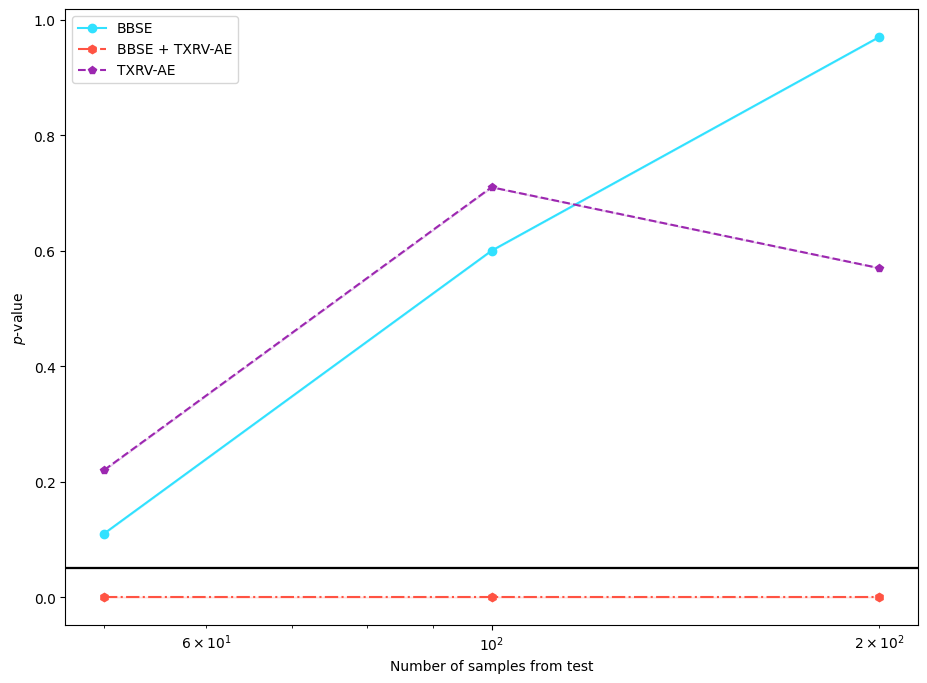

In [3]:
model = DenseNet(weights="densenet121-res224-all")
dr_methods = {
    "BBSE": "bbse-soft",
    "BBSE + TXRV-AE": "bbse-soft+txrv-ae",
    "TXRV-AE": "txrv-ae",
}
results = {}

for name, dr_method in dr_methods.items():
    if name == "TXRV-AE":
        reductor = Reductor(dr_method=dr_method, device=device)
    else:
        reductor = Reductor(dr_method=dr_method, model=model, device=device)
    detector = Detector(
        "sensitivity_test",
        reductor=reductor,
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    result = detector.detect_shift(source_ds, target_ds)
    results[name] = result
plot_drift_experiment(results)

## Example 3. Sensitivity test experiment with models trained on different datasets

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.06 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.74 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.34 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.99 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 49.28 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 51.84 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 51.65 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.30 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.29 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.01 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 29.48 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 38.19 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 16.97 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 27.88 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 36.71 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 42.35 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 47.22 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 48.94 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 47.92 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.78 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 28.93 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.17 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.30 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 47.27 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 50.16 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 48.75 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.85 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.65 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.75 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 29.40 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 37.22 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:10, 16.56 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 28.09 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 35.62 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 42.79 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 46.27 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 48.55 examples/s]

Map: 100%|██████████| 200/200 [00:05<00:00, 48.31 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.63 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.79 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.80 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.81 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.80 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 53.14 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.42 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.48 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.79 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:02<00:04, 15.72 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 27.33 examples/s]

Map:  96%|█████████▌| 96/100 [00:03<00:00, 35.10 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:02<00:10, 15.28 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:05, 26.81 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:03, 34.14 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 40.90 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 45.82 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 48.23 examples/s]

Map: 100%|██████████| 200/200 [00:05<00:00, 48.28 examples/s]

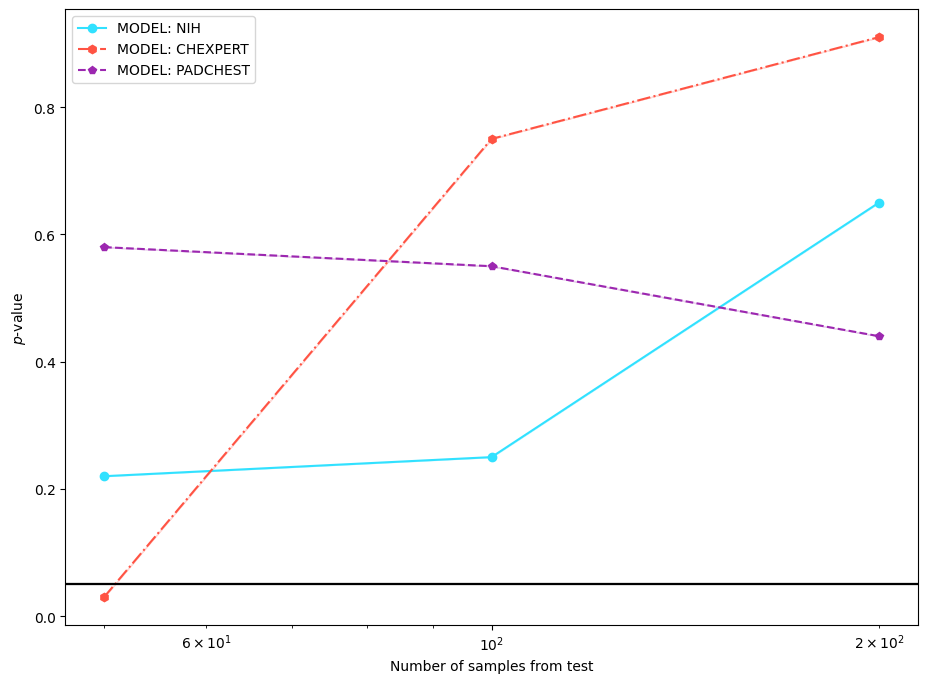

In [4]:
models = {
    "MODEL: NIH": "densenet121-res224-nih",
    "MODEL: CHEXPERT": "densenet121-res224-chex",
    "MODEL: PADCHEST": "densenet121-res224-pc",
}
results = {}

for model_name, model in models.items():
    detector = Detector(
        "sensitivity_test",
        reductor=Reductor(
            dr_method="bbse-soft", model=DenseNet(weights=model), device=device
        ),
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    results[model_name] = detector.detect_shift(source_ds, target_ds)
plot_drift_experiment(results)

## Example 4. Sensitivity test experiment with different clinical shifts

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 47096.00 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 68889.27 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 79586.10 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 81308.27 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 88125.53 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 90402.16 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:02, 44298.34 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 65471.10 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 76247.82 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:01<00:00, 82165.26 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 89597.25 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 94259.20 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:02<00:10, 15.84 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 28.25 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 37.59 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.84 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 49.51 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.73 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.47 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.99 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.25 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:02<00:04, 13.64 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 24.24 examples/s]

Map:  96%|█████████▌| 96/100 [00:03<00:00, 32.49 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:10, 16.31 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:05, 26.70 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 35.40 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 41.11 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 45.08 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 47.99 examples/s]

Map: 100%|██████████| 200/200 [00:05<00:00, 47.69 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  12%|█▏        | 13000/112120 [00:00<00:02, 33721.92 examples/s]

Filter (num_proc=6):  28%|██▊       | 31687/112120 [00:00<00:01, 57078.84 examples/s]

Filter (num_proc=6):  45%|████▍     | 50374/112120 [00:00<00:00, 69741.99 examples/s]

Filter (num_proc=6):  63%|██████▎   | 71061/112120 [00:00<00:00, 83022.01 examples/s]

Filter (num_proc=6):  83%|████████▎ | 92748/112120 [00:01<00:00, 95005.58 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 109347.79 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 47290.00 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 63574.61 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 72322.21 examples/s]

Filter (num_proc=6):  63%|██████▎   | 71061/112120 [00:01<00:00, 73410.87 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 87933.21 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 93219.03 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:02<00:11, 14.43 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:05, 25.94 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:03, 33.64 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 38.97 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 44.19 examples/s]

Map:  96%|█████████▌| 192/200 [00:05<00:00, 48.43 examples/s]

Map: 100%|██████████| 200/200 [00:05<00:00, 47.95 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:03<00:01, 10.25 examples/s]

Map: 100%|██████████| 50/50 [00:03<00:00, 15.72 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:02<00:05, 11.90 examples/s]

Map:  64%|██████▍   | 64/100 [00:03<00:01, 21.86 examples/s]

Map:  96%|█████████▌| 96/100 [00:03<00:00, 29.01 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:03<00:17,  9.80 examples/s]

Map:  32%|███▏      | 64/200 [00:03<00:07, 18.74 examples/s]

Map:  48%|████▊     | 96/200 [00:04<00:04, 24.59 examples/s]

Map:  64%|██████▍   | 128/200 [00:05<00:02, 31.45 examples/s]

Map:  80%|████████  | 160/200 [00:05<00:01, 36.80 examples/s]

Map:  96%|█████████▌| 192/200 [00:06<00:00, 41.08 examples/s]

Map: 100%|██████████| 200/200 [00:06<00:00, 40.76 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 47930.61 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 67668.81 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 77526.59 examples/s]

Filter (num_proc=6):  64%|██████▍   | 72061/112120 [00:01<00:00, 75986.30 examples/s]

Filter (num_proc=6):  76%|███████▋  | 85748/112120 [00:01<00:00, 73222.85 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 94017.14 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  15%|█▌        | 17000/112120 [00:00<00:02, 41809.81 examples/s]

Filter (num_proc=6):  28%|██▊       | 31687/112120 [00:00<00:01, 51839.11 examples/s]

Filter (num_proc=6):  49%|████▉     | 55374/112120 [00:00<00:00, 69935.62 examples/s]

Filter (num_proc=6):  62%|██████▏   | 70061/112120 [00:01<00:00, 69509.21 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 83626.07 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 90682.53 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.03 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.75 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 36.10 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 42.35 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 46.62 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 47.05 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 47.15 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:02<00:01, 12.68 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 18.67 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:02<00:04, 14.87 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 25.45 examples/s]

Map:  96%|█████████▌| 96/100 [00:03<00:00, 32.88 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:02<00:15, 11.05 examples/s]

Map:  32%|███▏      | 64/200 [00:03<00:06, 20.32 examples/s]

Map:  48%|████▊     | 96/200 [00:04<00:03, 27.40 examples/s]

Map:  64%|██████▍   | 128/200 [00:04<00:02, 33.42 examples/s]

Map:  80%|████████  | 160/200 [00:05<00:01, 39.28 examples/s]

Map:  96%|█████████▌| 192/200 [00:06<00:00, 42.24 examples/s]

Map: 100%|██████████| 200/200 [00:06<00:00, 41.56 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  15%|█▌        | 17000/112120 [00:00<00:02, 42177.57 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 65988.51 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 73882.72 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:01<00:00, 78429.83 examples/s]

Filter (num_proc=6):  83%|████████▎ | 92748/112120 [00:01<00:00, 78998.16 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 84596.40 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 47175.46 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 68335.89 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 79590.41 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 85605.88 examples/s]

Filter (num_proc=6):  76%|███████▋  | 85748/112120 [00:01<00:00, 73617.09 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 94384.21 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.27 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.31 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.85 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.20 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.53 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.78 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.34 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:02<00:01, 13.26 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 19.46 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.53 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 29.63 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 37.28 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:02<00:13, 12.49 examples/s]

Map:  32%|███▏      | 64/200 [00:03<00:05, 22.78 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:03, 30.46 examples/s]

Map:  64%|██████▍   | 128/200 [00:04<00:02, 35.97 examples/s]

Map:  80%|████████  | 160/200 [00:05<00:00, 40.80 examples/s]

Map:  96%|█████████▌| 192/200 [00:05<00:00, 43.58 examples/s]

Map: 100%|██████████| 200/200 [00:05<00:00, 43.39 examples/s]

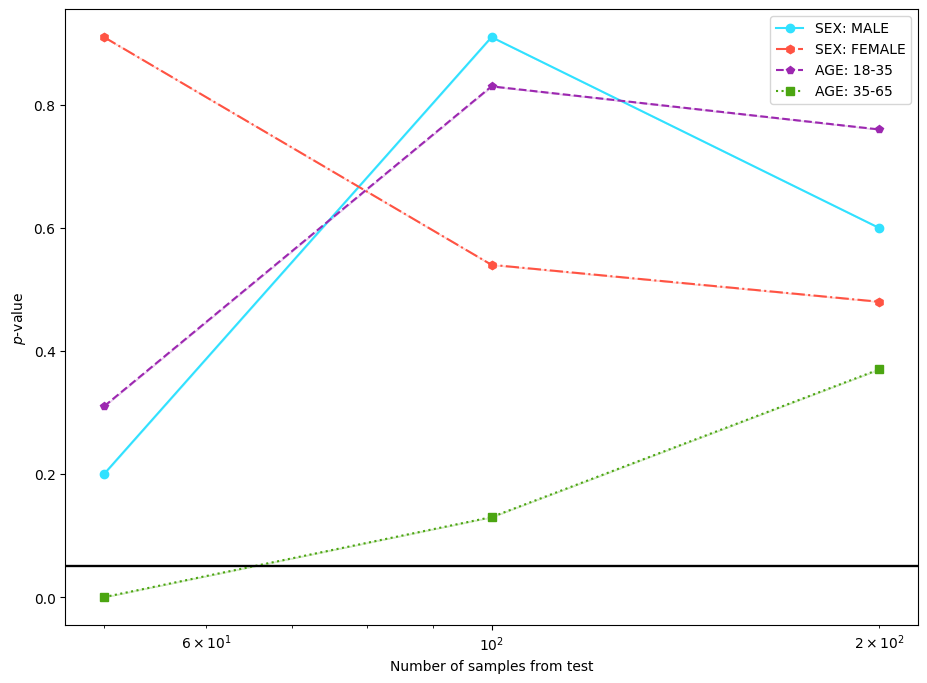

In [5]:
model = DenseNet(weights="densenet121-res224-all")
source_slice = None
target_slices = {
    "SEX: MALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "M"}}]),
    "SEX: FEMALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "F"}}]),
    "AGE: 18-35": SliceSpec(
        spec_list=[{"Patient Age": {"min_value": 18, "max_value": 35}}]
    ),
    "AGE: 35-65": SliceSpec(
        spec_list=[{"Patient Age": {"min_value": 35, "max_value": 65}}]
    ),
}
results = {}

for name, target_slice in target_slices.items():
    source_slice = None
    shifter = ClinicalShiftApplicator(
        "custom", source=source_slice, target=target_slice
    )
    ds_source, ds_target = shifter.apply_shift(nih_ds, num_proc=6)

    ds_source = ds_source.with_transform(
        partial(apply_transforms, transforms=transforms),
        columns=["features"],
        output_all_columns=True,
    )
    ds_target = ds_target.with_transform(
        partial(apply_transforms, transforms=transforms),
        columns=["features"],
        output_all_columns=True,
    )

    detector = Detector(
        "sensitivity_test",
        reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    results[name] = detector.detect_shift(ds_source, ds_target)
plot_drift_experiment(results)

## Example 5. Rolling window experiment with synthetic timestamps using biweekly window

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.36 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.50 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.63 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.57 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.03 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 49.76 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 49.84 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.84 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.58 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.93 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.67 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.46 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.41 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.92 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.34 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.73 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.99 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.80 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.91 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.06 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.73 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.50 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.98 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.20 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.73 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.47 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.77 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.22 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.91 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.90 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.08 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.96 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.18 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.07 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.93 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.01 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.86 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.30 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.30 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.83 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.98 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.87 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.48 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.57 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.55 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.90 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 27.03 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.45 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.88 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.15 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.23 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.71 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.59 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.03 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.09 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.69 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.41 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.51 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.65 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.36 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.25 examples/s]

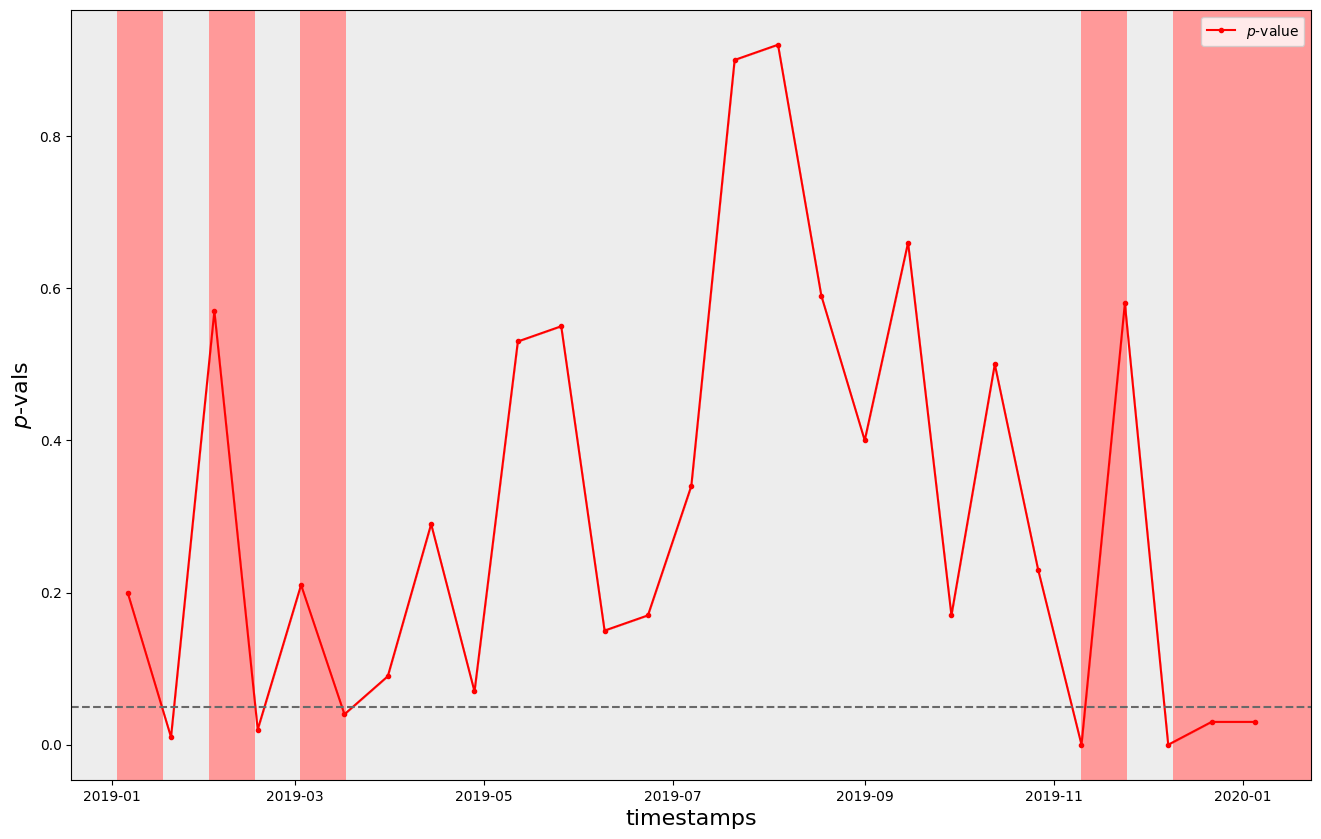

In [6]:
model = DenseNet(weights="densenet121-res224-all")
detector = Detector(
    "rolling_window_drift",
    reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
    tester=TSTester(tester_method="mmd"),
    source_sample_size=200,
    target_sample_size=50,
    timestamp_column="timestamp",
    window_size="2W",
)

results = detector.detect_shift(source_ds, target_ds)
plot_drift_timeseries(results)